In [14]:
import json
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from shapely.geometry import Polygon, Point
from shapely.ops import cascaded_union
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area

ModuleNotFoundError: No module named 'geovoronoi'

In [22]:
import math, random

random.seed(42)
np.random.seed(42)

def generatePolygon( ctrX, ctrY, aveRadius, irregularity, spikeyness, numVerts ) :
    '''
    Start with the centre of the polygon at ctrX, ctrY, 
    then creates the polygon by sampling points on a circle around the centre. 
    Randon noise is added by varying the angular spacing between sequential points,
    and by varying the radial distance of each point from the centre.

    Params:
    ctrX, ctrY - coordinates of the "centre" of the polygon
    aveRadius - in px, the average radius of this polygon, this roughly controls how large the polygon is, really only useful for order of magnitude.
    irregularity - [0,1] indicating how much variance there is in the angular spacing of vertices. [0,1] will map to [0, 2pi/numberOfVerts]
    spikeyness - [0,1] indicating how much variance there is in each vertex from the circle of radius aveRadius. [0,1] will map to [0, aveRadius]
    numVerts - self-explanatory

    Returns a list of vertices, in CCW order.
    '''

    irregularity = clip( irregularity, 0,1 ) * 2*math.pi / numVerts
    spikeyness = clip( spikeyness, 0,1 ) * aveRadius

    # generate n angle steps
    angleSteps = []
    lower = (2*math.pi / numVerts) - irregularity
    upper = (2*math.pi / numVerts) + irregularity
    sum = 0
    for i in range(numVerts) :
        tmp = random.uniform(lower, upper)
        angleSteps.append( tmp )
        sum = sum + tmp

    # normalize the steps so that point 0 and point n+1 are the same
    k = sum / (2*math.pi)
    for i in range(numVerts) :
        angleSteps[i] = angleSteps[i] / k

    # now generate the points
    points = []
    angle = random.uniform(0, 2*math.pi)
    for i in range(numVerts) :
        r_i = clip( random.gauss(aveRadius, spikeyness), 0, 2*aveRadius )
        x = ctrX + r_i*math.cos(angle)
        y = ctrY + r_i*math.sin(angle)
        points.append( (int(x),int(y)) )

        angle = angle + angleSteps[i]

    return points

def clip(x, min, max) :
    if( min > max ) :  return x    
    elif( x < min ) :  return min
    elif( x > max ) :  return max
    else :             return x

In [4]:
def generateArea(poly_out,poly_in1,poly_in2,pts):
    
    region = poly_out.difference(poly_in1)
    region = region.difference(poly_in2)
    
    # voronoi
    pts = pts[pts.intersects(region.unary_union)]
    pts = points_to_coords(pts.geometry)
    
    boundary_shape = cascaded_union(region.geometry)
    poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(pts, boundary_shape)
    
    final = gpd.GeoSeries(poly_shapes)
    final=gpd.GeoDataFrame(pd.concat([poly_in1,poly_in2,final],axis=0,ignore_index=True),columns=['geometry'])
    final['id'] = final.index.values
    final['highlight'] = [1,1]+([0] * (len(final)-2))
    
    return final

# Preparation

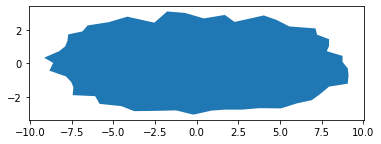

In [13]:
pts = generatePolygon(0, 0, 200, 0.25, 0.05, 50)
poly_out = Polygon([pt for pt in pts])
poly_out = gpd.GeoSeries([poly_out])
poly_out = poly_out.scale(xfact=9,yfact=3)
poly_out = poly_out.scale(xfact=1.0/200.0,yfact=1.0/200.0,origin=(0, 0))
poly_out.plot()
plt.show()

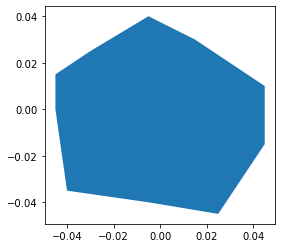

In [16]:
pts = generatePolygon(0, 0, 10, 0.5, 0.1, 10)
poly_in = Polygon([pt for pt in pts])
poly_in = gpd.GeoSeries([poly_in])
poly_in = poly_in.scale(xfact=1.0/200.0,yfact=1.0/200.0,origin=(0, 0))
poly_in.plot()
plt.show()

In [17]:
poly_out.bounds

,minx,miny,maxx,maxy
0,-9.155,-3.08,9.115,3.115


In [18]:
def create_point(p):
    width = float(poly_out.bounds.maxx-poly_out.bounds.minx)
    height = float(poly_out.bounds.maxy-poly_out.bounds.miny)
    return Point((width*p[0]+poly_out.bounds.minx),(height*p[1]+poly_out.bounds.miny))

num_pts = 98
pts = []
while len(pts) < num_pts:
    newpts = gpd.GeoSeries([create_point(p) for p in np.random.rand(num_pts-len(pts),2)])
    pts = newpts.append(pts)
    pts = pts[pts.intersects(poly_out.unary_union)]
print(len(pts))

98


# Distance geometries

98


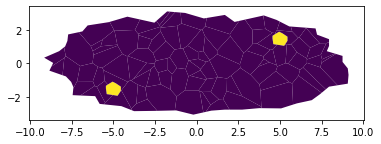

In [21]:
gdf = generateArea(poly_out,poly_in.scale(10,10,origin=(0,0)).translate(-5,-1.5),poly_in.scale(10,10,origin=(0,0)).translate(5,1.5),pts)
gdf.plot(column='highlight')
gdf.to_file('data/distance/distance_far.geojson', driver='GeoJSON')
print(len(gdf))

99


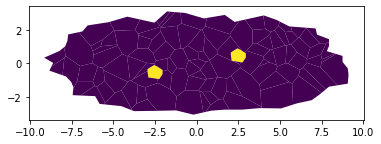

In [23]:
gdf = generateArea(poly_out,poly_in.scale(10,10,origin=(0,0)).translate(-2.5,-.5),poly_in.scale(10,10,origin=(0,0)).translate(2.5,.5),pts)
gdf.plot(column='highlight')
gdf.to_file('data/distance/distance_medium.geojson', driver='GeoJSON')
print(len(gdf))

99


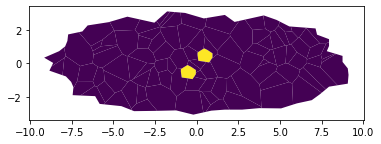

In [24]:
gdf = generateArea(poly_out,poly_in.scale(10,10,origin=(0,0)).translate(-.5,-.5),poly_in.scale(10,10,origin=(0,0)).translate(.5,.5),pts)
gdf.plot(column='highlight')
gdf.to_file('data/distance/distance_near.geojson', driver='GeoJSON')
print(len(gdf))

# Size geometries

98


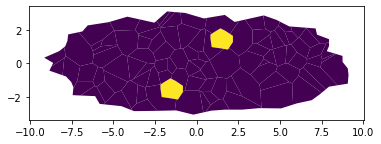

In [25]:
gdf = generateArea(poly_out,poly_in.scale(15,15,origin=(0, 0)).translate(1.5,1.5),poly_in.scale(15,15,origin=(0, 0)).translate(-1.5,-1.5),pts)
gdf.plot(column='highlight')
gdf.to_file('data/size/size_large.geojson', driver='GeoJSON')
print(len(gdf))

99


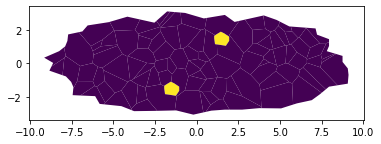

In [28]:
gdf = generateArea(poly_out,poly_in.scale(10,10,origin=(0,0)).translate(1.5,1.5),poly_in.scale(10,10,origin=(0,0)).translate(-1.5,-1.5),pts)
gdf.plot(column='highlight')
gdf.to_file('data/size/size_medium.geojson', driver='GeoJSON')
print(len(gdf))

99


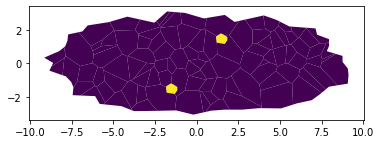

In [30]:
gdf = generateArea(poly_out,poly_in.scale(7.5,7.5,origin=(0,0)).translate(1.5,1.5),poly_in.scale(7.5,7.5,origin=(0,0)).translate(-1.5,-1.5),pts)
gdf.plot(column='highlight')
gdf.to_file('data/size/size_small.geojson', driver='GeoJSON')
print(len(gdf))

# Number of regions geometries

In [31]:
num_pts = 50
pts_small = []
while len(pts_small) < num_pts:
    newpts = gpd.GeoSeries([create_point(p) for p in np.random.rand(num_pts-len(pts_small),2)])
    pts_small = newpts.append(pts_small)
    pts_small = pts_small[pts_small.intersects(poly_out.unary_union)]
print(len(pts_small))

50


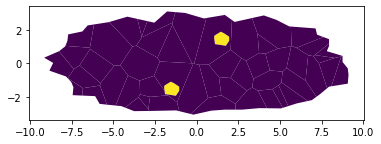

In [32]:
gdf = generateArea(poly_out,poly_in.scale(10,10,origin=(0,0)).translate(1.5,1.5),poly_in.scale(10,10,origin=(0,0)).translate(-1.5,-1.5),pts_small)
gdf.plot(column='highlight')
gdf.to_file('data/number_regions/number_regions_small.geojson', driver='GeoJSON')

In [33]:
num_pts = 100
pts_medium = []
while len(pts_medium) < num_pts:
    newpts = gpd.GeoSeries([create_point(p) for p in np.random.rand(num_pts-len(pts_medium),2)])
    pts_medium = newpts.append(pts_medium)
    pts_medium = pts_medium[pts_medium.intersects(poly_out.unary_union)]
print(len(pts_medium))

100


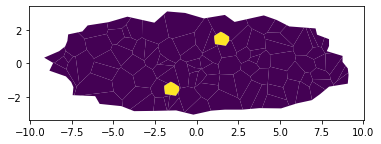

In [37]:
gdf = generateArea(poly_out,poly_in.scale(10,10,origin=(0,0)).translate(1.5,1.5),poly_in.scale(10,10,origin=(0,0)).translate(-1.5,-1.5),pts_medium)
gdf.plot(column='highlight')
gdf.to_file('data/number_regions/number_regions_medium.geojson', driver='GeoJSON')

In [35]:
num_pts = 150
pts_large = []
while len(pts_large) < num_pts:
    newpts = gpd.GeoSeries([create_point(p) for p in np.random.rand(num_pts-len(pts_large),2)])
    pts_large = newpts.append(pts_large)
    pts_large = pts_large[pts_large.intersects(poly_out.unary_union)]
print(len(pts_large))

150


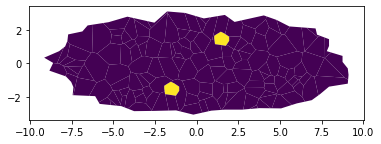

In [36]:
gdf = generateArea(poly_out,poly_in.scale(10,10,origin=(0,0)).translate(1.5,1.5),poly_in.scale(10,10,origin=(0,0)).translate(-1.5,-1.5),pts_large)
gdf.plot(column='highlight')
gdf.to_file('data/number_regions/number_regions_large.geojson', driver='GeoJSON')

# Variance geometries

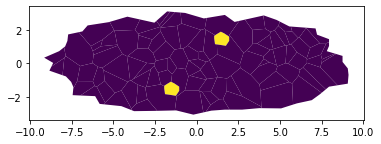

In [38]:
gdf = generateArea(poly_out,poly_in.scale(10,10,origin=(0,0)).translate(1.5,1.5),poly_in.scale(10,10,origin=(0,0)).translate(-1.5,-1.5),pts)
gdf.plot(column='highlight')
gdf.to_file('data/variance/variance.geojson', driver='GeoJSON')

# Probability geometry

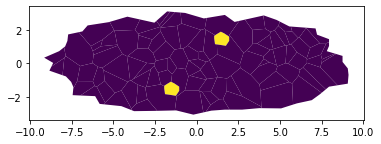

In [46]:
gdf = generateArea(poly_out,poly_in.scale(10,10,origin=(0,0)).translate(1.5,1.5),poly_in.scale(10,10,origin=(0,0)).translate(-1.5,-1.5),pts)
gdf.plot(column='highlight')
gdf.to_file('data/probability/probability.geojson', driver='GeoJSON')

# Distributions

In [31]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def output_distribution(out_filename, values):
    out = {}
    for i in range(0,len(values[0])):
        out[i] = {}
        for j in range(0,len(values)):
            out[i][j] = values[j][i]
    with open(out_filename, 'w', encoding='utf-8') as f:
        json.dump(out, f, ensure_ascii=False, indent=4)

In [32]:
other_areas_mean = [40,45,50,60,80,85,55,60]
other_areas_std = [15,20,2,15,15,10,2,15]

# dist_1 = [{'mean': 40, 'std': 15},{'mean': 45, 'std': 15}]
# dist_2 = [{'mean': 50, 'std': 10},{'mean': 60, 'std': 10}]
# dist_3 = [{'mean': 80, 'std': 2}, {'mean': 85, 'std': 2}]
# dist_4 = [{'mean': 55, 'std': 15},{'mean': 60, 'std': 15}]

In [33]:
# distance
nSamples = 1000
values = []
values.append(np.random.normal(40, 15, nSamples))
values.append(np.random.normal(45, 15, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/distance/distance_1.json', values)

values = []
values.append(np.random.normal(60, 10, nSamples))
values.append(np.random.normal(50, 10, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/distance/distance_2.json', values)

values = []
values.append(np.random.normal(80, 2, nSamples))
values.append(np.random.normal(85, 2, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/distance/distance_3.json', values)

values = []
values.append(np.random.normal(60, 15, nSamples))
values.append(np.random.normal(55, 15, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/distance/distance_4.json', values)

In [34]:
# size
values = []
values.append(np.random.normal(40, 15, nSamples))
values.append(np.random.normal(45, 15, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/size/size_1.json', values)

values = []
values.append(np.random.normal(60, 10, nSamples))
values.append(np.random.normal(50, 10, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/size/size_2.json', values)

values = []
values.append(np.random.normal(80, 2, nSamples))
values.append(np.random.normal(85, 2, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/size/size_3.json', values)

values = []
values.append(np.random.normal(60, 15, nSamples))
values.append(np.random.normal(55, 15, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/size/size_4.json', values)

In [35]:
# number of regions
values = []
values.append(np.random.normal(40, 15, nSamples))
values.append(np.random.normal(45, 15, nSamples))
for i in range(0,150-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/number_regions/number_regions_1.json', values)

values = []
values.append(np.random.normal(60, 10, nSamples))
values.append(np.random.normal(50, 10, nSamples))
for i in range(0,150-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/number_regions/number_regions_2.json', values)

values = []
values.append(np.random.normal(80, 2, nSamples))
values.append(np.random.normal(85, 2, nSamples))
for i in range(0,150-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/number_regions/number_regions_3.json', values)

values = []
values.append(np.random.normal(60, 15, nSamples))
values.append(np.random.normal(55, 15, nSamples))
for i in range(0,150-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/number_regions/number_regions_4.json', values)

In [36]:
# variance
values = []
values.append(np.random.normal(40, 15, nSamples))
values.append(np.random.normal(45, 15, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/variance/variance_1.json', values)

values = []
values.append(np.random.normal(60, 10, nSamples))
values.append(np.random.normal(50, 10, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/variance/variance_2.json', values)

values = []
values.append(np.random.normal(80, 2, nSamples))
values.append(np.random.normal(85, 2, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/variance/variance_3.json', values)

values = []
values.append(np.random.normal(60, 15, nSamples))
values.append(np.random.normal(55, 15, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/variance/variance_4.json', values)

In [5]:
# Pr(B > A)
values = []
values.append(np.random.normal(40, 15, nSamples))
values.append(np.random.normal(45, 15, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/probability/probability_small.json', values)

values = []
values.append(np.random.normal(50, 10, nSamples))
values.append(np.random.normal(60, 10, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/probability/probability_medium.json', values)

values = []
values.append(np.random.normal(80, 2, nSamples))
values.append(np.random.normal(85, 2, nSamples))
for i in range(0,100-len(values)):
    aux = np.random.normal(random.choice(other_areas_mean), random.choice(other_areas_std), nSamples)
    values.append(aux)
output_distribution('data/probability/probability_large.json', values)

NameError: name 'np' is not defined

# Rest...

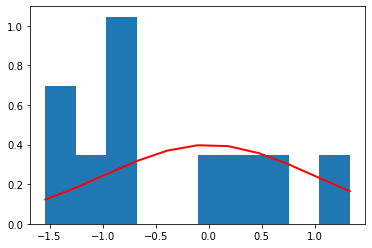

0.8310737522215677

In [483]:
mu, sigma = 0, 1
aux = np.random.normal(mu,sigma,10)
count, bins, ignored = plt.hist(aux,10,density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
plt.show()
np.var(aux)

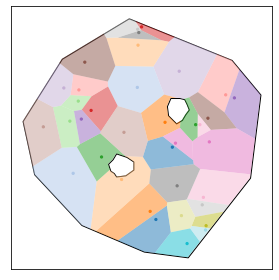

In [36]:
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, poly_shapes, pts, poly_to_pt_assignments)
plt.tight_layout()
plt.show()